<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Information Theory and Inference<b> </div>
<div style="text-align:right"><strong>Year: </strong>2024-2025<b> </div>
    

#### Students:
- Bertinelli Gabriele - 2103359 - gabriele.bertinelli@studenti.unipd.it
- Lovato Matteo - 2104269 - matteo.lovato.3@studenti.unipd.it

    
<strong>Exam Date</strong>: February, 21st 2025
    
<center>
    
# Approximate Bayes Computation: application on the SIR model
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

In [1]:
from PIL import Image

## SIR Model

The **SIR model** is a mathematical tool to model the spreading of infectuous diseases. It is a stochastic model, including three possible states for a population:
- _susceptible_ (S): individuals who have not suffered of the disease yet;
- _infected_ (I): individuals who are currently suffering of the disease; 
- _recovered_ (R): individuals who have recovered o have died from the disease. 

SIR model describes the flow of individuals from S to I and then from I to R by a set of ordinary differential equations:
$$
\begin{cases}
\frac{dS(t)}{dt} &= -\beta S(t)P(t) \\
\frac{dI(t)}{dt} &= \beta S(t)P(t) - \gamma I (t) \\
\frac{dR (t)}{dt} &= \gamma I (t)
\end{cases}
$$
where $P(t)=I(t)/N$ is the proportion of infectuous individuals at time $t$, $\beta$ is the transmission rate parameter and $\gamma$ the removal rate parameter. The sum of $S(t)$, $I(t)$ and $R(t)$ gives at any moment the total population $N$. <u>**The goal of our work is to infer the parameters $\beta$ and $\gamma$**</u>.

We derived the model used in this analysis by the one proposed in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y).  
Let $\Delta I = (\Delta I_1,...,\Delta I_\text{T})^T $ and $\Delta R = (\Delta R_1,...,\Delta R_\text{T})^T $  be sequences of daily reported numbers of newly infected (confirmed) cases and removed cases respectively. Given the initial state of the population $(S_0,I_0,R_0)$, we write the discrete-time stochastic SIR model as follows:
$$
\begin{equation*}
\begin{cases}
\Delta I_t \sim \text{Binomial}\left(S_{t-1}, 1 - \exp(-\beta_t P_{t-1})\right) \\
\Delta R_t \sim \text{Binomial}\left(I_{t-1}, \gamma_t\right) \\
S_t = S_{t-1} - \Delta I_t \\
I_t = I_{t-1} + \Delta I_t - \Delta R_t \\
R_t = R_{t-1} + \Delta R_t
\end{cases}
\end{equation*}
$$

### "Observed" data
The shapes of the priors are the one considered in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y):

$$ \beta \sim Exp(\lambda=0.1)$$
$$\gamma \sim Beta(\alpha=0.01, \beta=1)$$

We generated a timeseries, i.e. our observed data, at fiducial parameter values

$$ \beta = 0.01 $$
$$ \gamma = 0.1 $$

The parameter values were chosen to be in line with typical values found in the literature.

Being it a stochastic model, the shape of the distribution is not fixed, rather it will have an "intrinsic" noise which will impact on the acceptance rate of the samples. However, usually this appears to be of small magnitude.

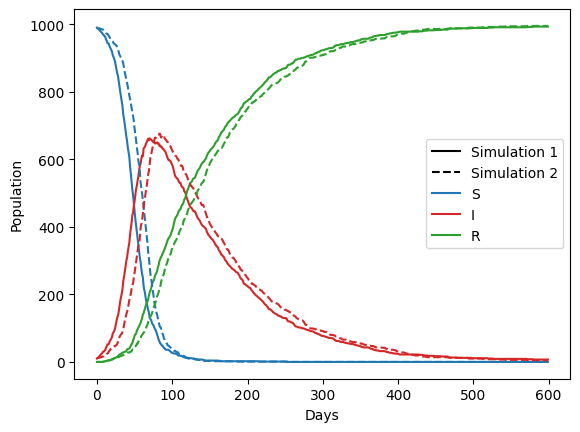

In [16]:
Image.open('./py_code/plot/SIR_sims.png')

## Approximate Bayesian Computation (ABC)

In statistical inference, there exist cases in which the likelihood $\mathcal{L}=\pi(d|\theta)$ may be unavailable, either because of mathematical or computational reasons.  
The ABC algorithm uses our ability to simulate physical process to bypass the necessity of a $\mathcal{L}$. 
It is based on the following crucial elements:

- a simulator, or forward model
- prior distributions over the input parameters $p(\bm{\theta})$
- a distance function $\varrho(\mathcal{D}_1, \mathcal{D}_2)$
- a threshold 

The main idea behind the ABC algorithm can be summarized in three main steps:

1. draw a large number of parameter values $\bm{\theta}^i$, from the prior distribution
2. $\forall \bm{\theta}^i$ generate a simulation $\mathcal{D}^i_S$ and calculate the distance between the observed to the simulated catalogues: $\rho_i=\rho(\mathcal{D}, \mathcal{D}^i_S)$
3. approximate the posterior distribution using the fraction of $\bm{\theta}^i$ with smallest associated distances.